In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

## 1. Open the data
#### This notebook is made for the test of visualizing the Pearson Correlation coefficient vs. nside or pixel size
#### /home/inlabru_project/micecat2_data_small.csv.bz2 is 1/256 of full datasets, for testing

In [2]:
def read_pandas(catalog_filename, index_col=None, chunksize=10000):
    dtype_dict = {'col1': 'int32', 'col2': 'float32'}  # Define appropriate types for each column
    for chunk in pd.read_csv(catalog_filename, sep=",", index_col=index_col, comment='#', na_values=r'\N', 
                             compression='bz2', chunksize=chunksize, dtype=dtype_dict):
        print(chunk.head())  # Process or use data here
        return chunk

In [3]:
# Define the path to the catalog compressed CSV file:
catalog_filename = "/home/inlabru_project/micecat2_data_small.csv.bz2"
index_col = ["unique_gal_id"]
chunksize = 200_000_000
data_gal = read_pandas(catalog_filename, index_col=index_col, chunksize=chunksize)

                  ra_gal    dec_gal   z_cgal  z_cgal_v  z_desdm_mc
unique_gal_id                                                     
373143579      26.422090  48.192754  1.01901   1.01948    1.104372
486189851      72.937500  41.313107  0.44484   0.44537    0.340315
483061019      78.743395   7.139959  0.28544   0.28609    0.272318
480245787      30.590492   1.145979  0.41121   0.41156    0.416370
18480155       32.157218  42.723187  0.22479   0.22342    0.223840


In [4]:
# Getting the data from
ra      = data_gal["ra_gal"] # Right ascension in degrees
dec     = data_gal["dec_gal"] # Declination in degrees
z       = data_gal["z_cgal"] # Redshift
z_photo = data_gal["z_desdm_mc"] # Photometric redshift

## 2. Healpix
#### Maybe 14 photometric redshifts bins?
#### Counts the number of galaxy in each pixels.

In [5]:
# Define the number of bins
num_bins = 14

# Create bins for the redshifts
z_bins = pd.cut(z, bins=num_bins, labels=False)

# Split the data for each redshift bin
binned_data = {}
for i in range(num_bins):
    binned_data[i] = data_gal[z_bins == i]

# Print the number of entries in each bin
for i in range(num_bins):
    print(f"Bin {i}: {len(binned_data[i])} entries")

Bin 0: 76492 entries
Bin 1: 130489 entries
Bin 2: 160351 entries
Bin 3: 174489 entries
Bin 4: 169447 entries
Bin 5: 169296 entries
Bin 6: 178829 entries
Bin 7: 178017 entries
Bin 8: 163347 entries
Bin 9: 139010 entries
Bin 10: 123858 entries
Bin 11: 111204 entries
Bin 12: 95128 entries
Bin 13: 81857 entries


In [6]:
def Healpix_map(bin_num, nside=64):
    ra = binned_data[bin_num]["ra_gal"]
    dec = binned_data[bin_num]["dec_gal"]
    # Convert the ra and dec to theta and phi
    theta = np.pi/2 - np.deg2rad(dec)
    phi = np.deg2rad(ra)
    
    # Get the pixel number for each ra, dec pair
    pixels = hp.ang2pix(nside, theta, phi)
    
    # Create a HEALPix map with the number of galaxies in each pixel
    Healpix_map = np.bincount(pixels, minlength=hp.nside2npix(nside))
    return Healpix_map

def visualize_healpix(healthpix_map):
    hp.mollview(healthpix_map, title="MICECAT2", cmap="viridis")
    hp.graticule()
    plt.show()

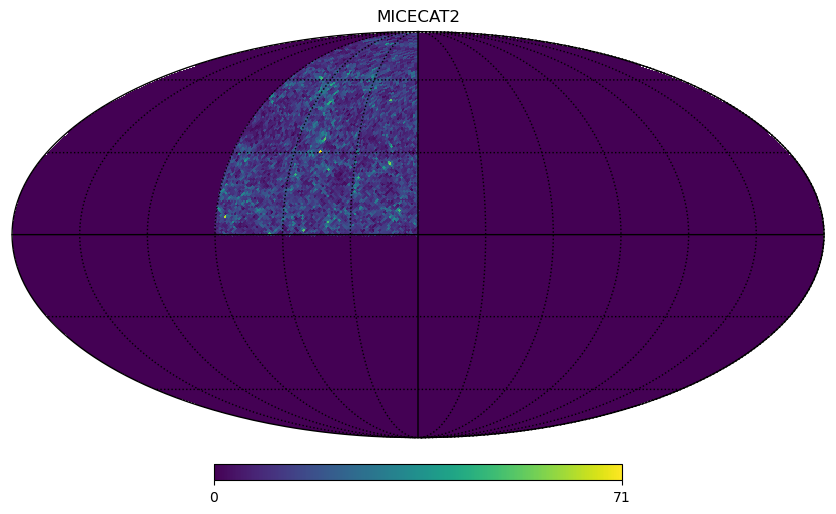

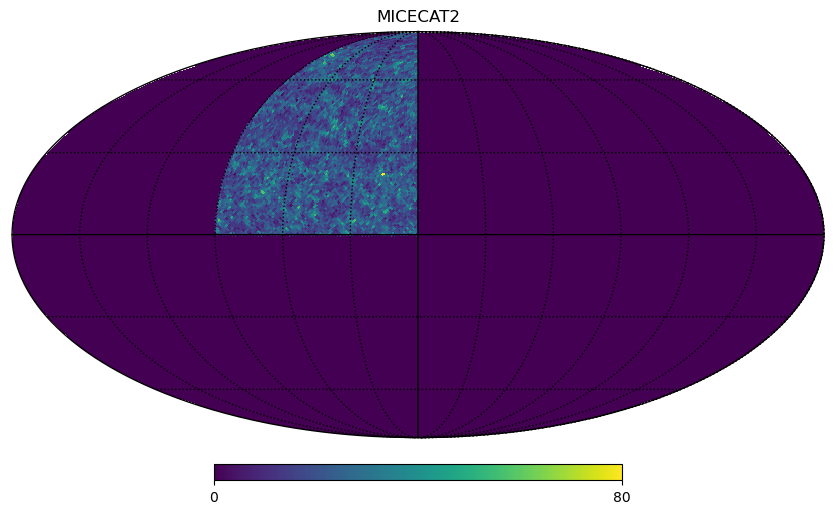

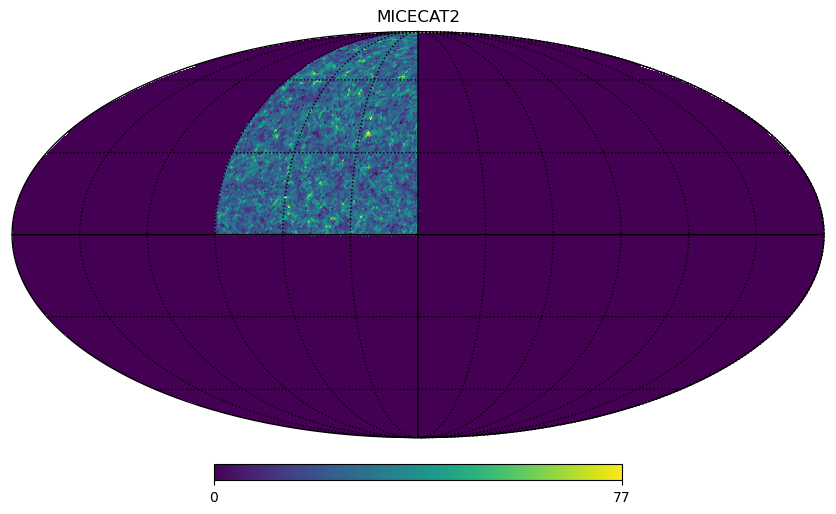

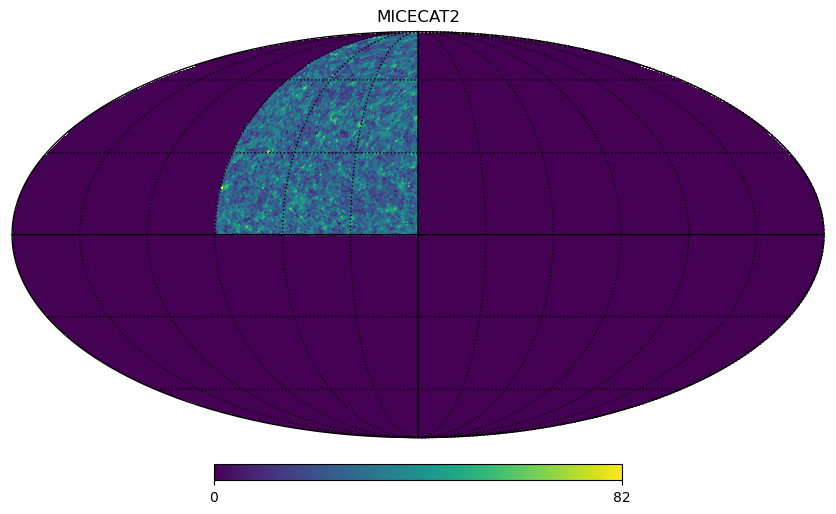

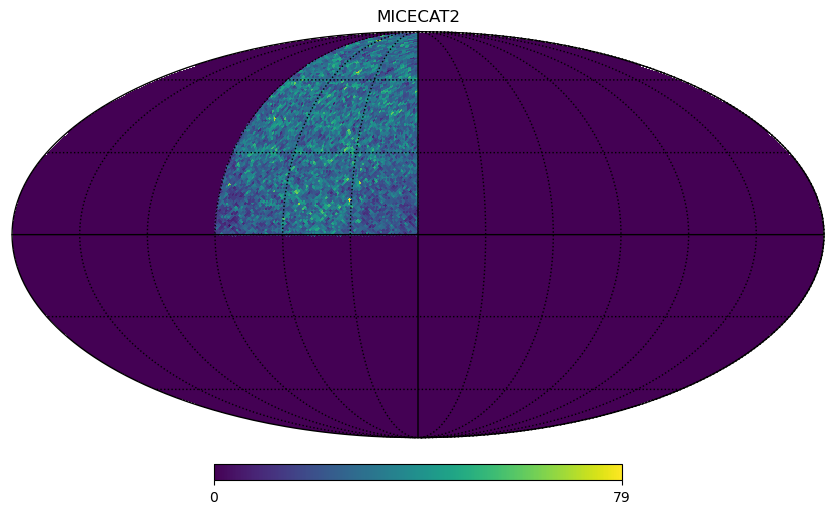

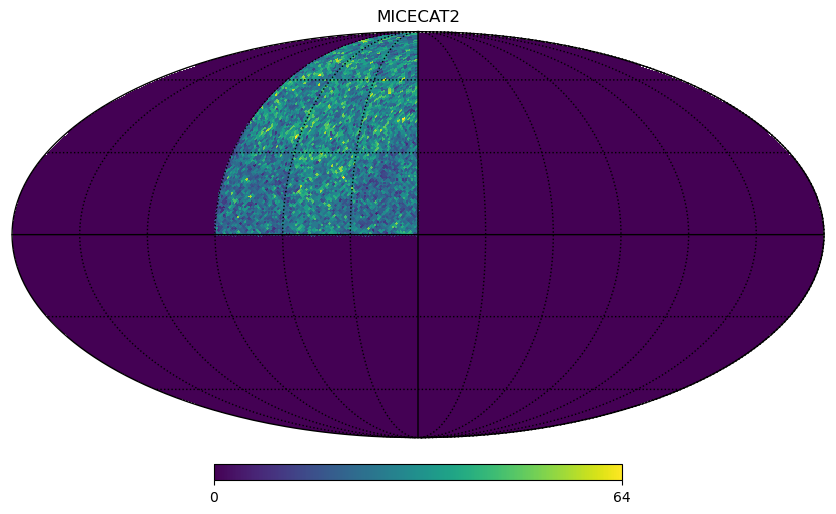

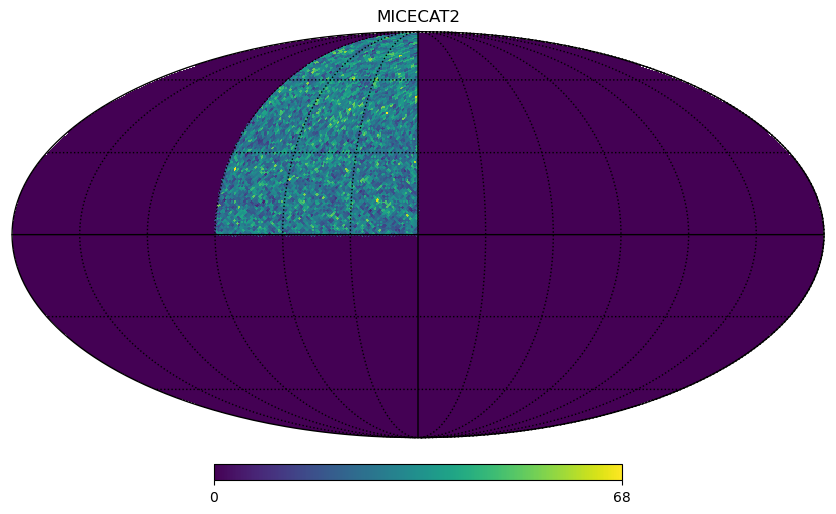

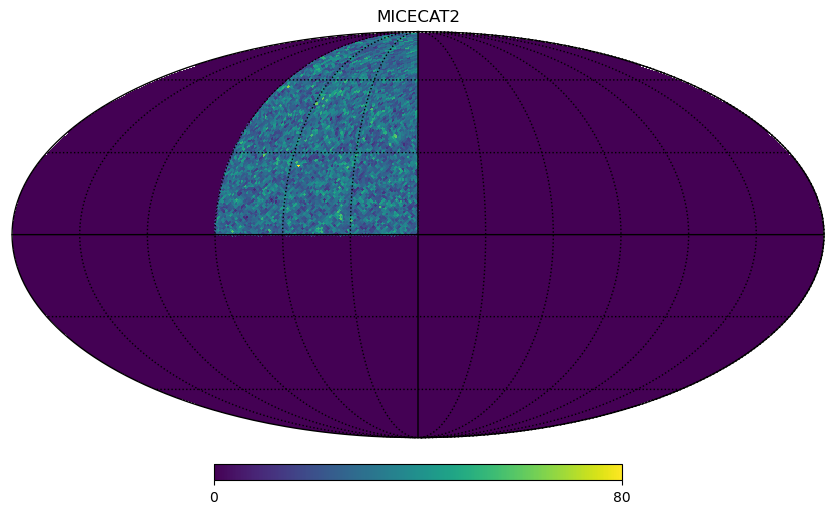

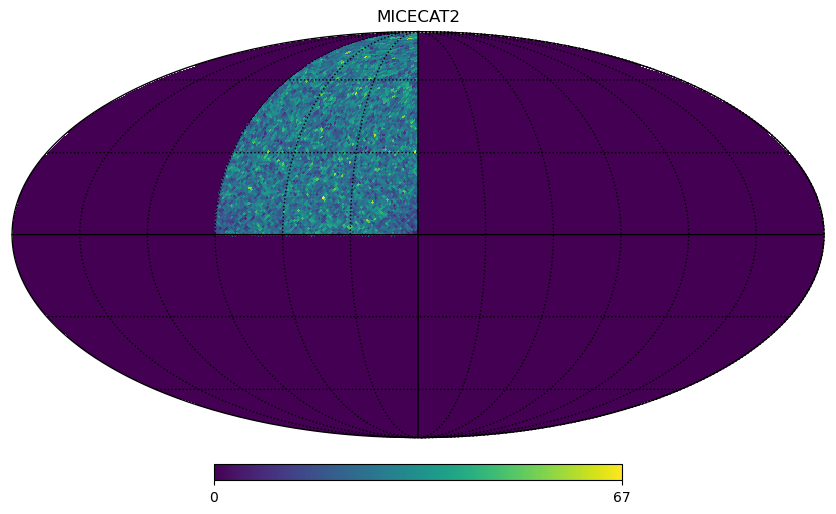

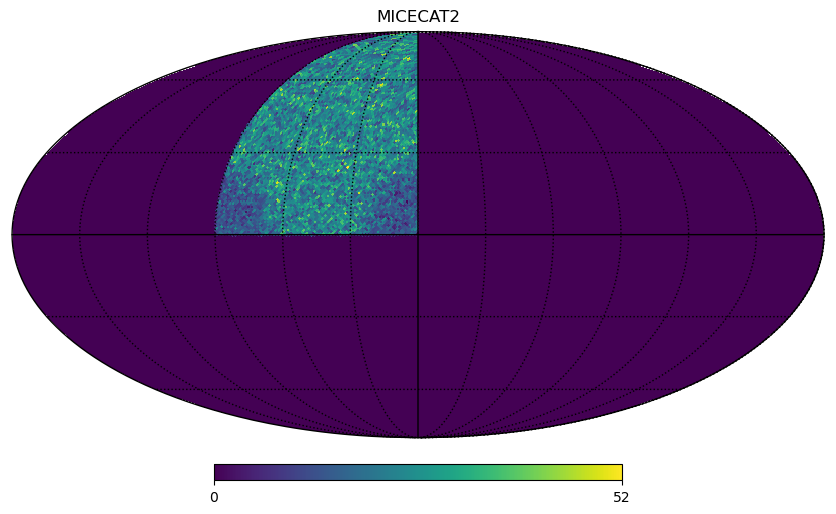

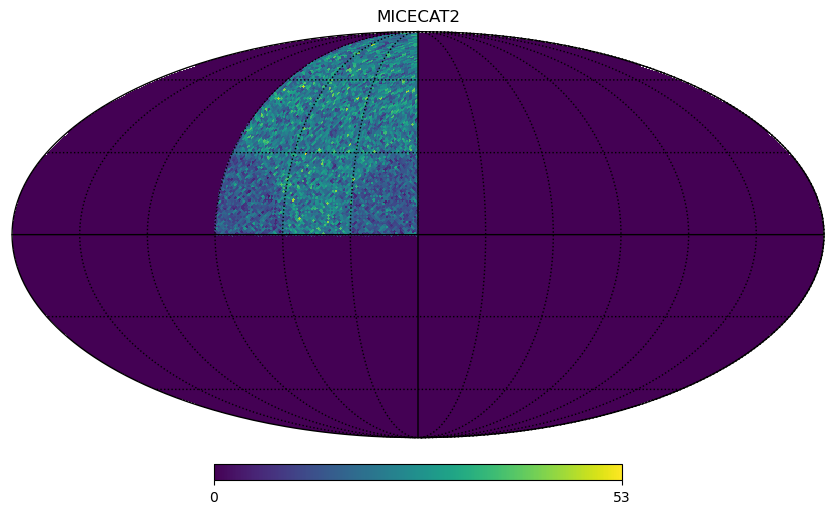

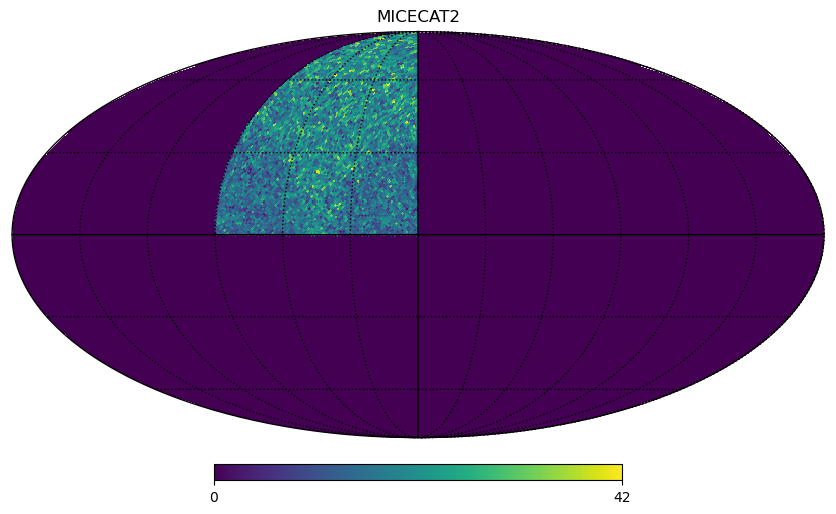

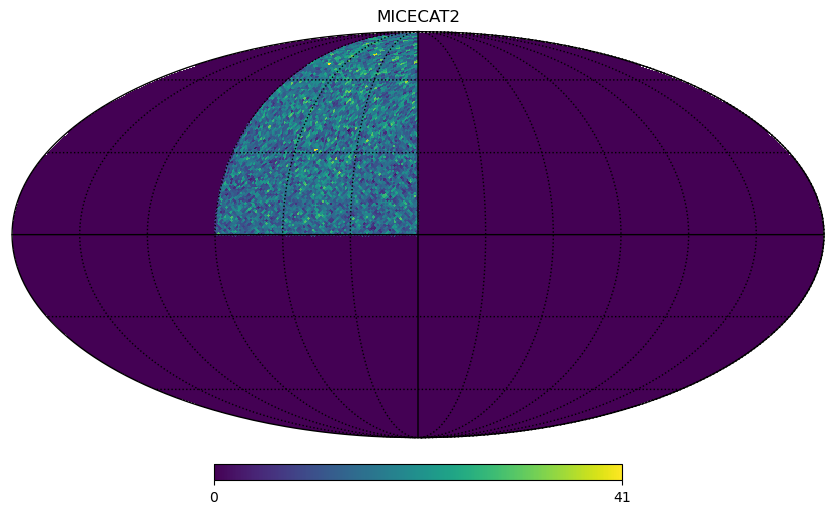

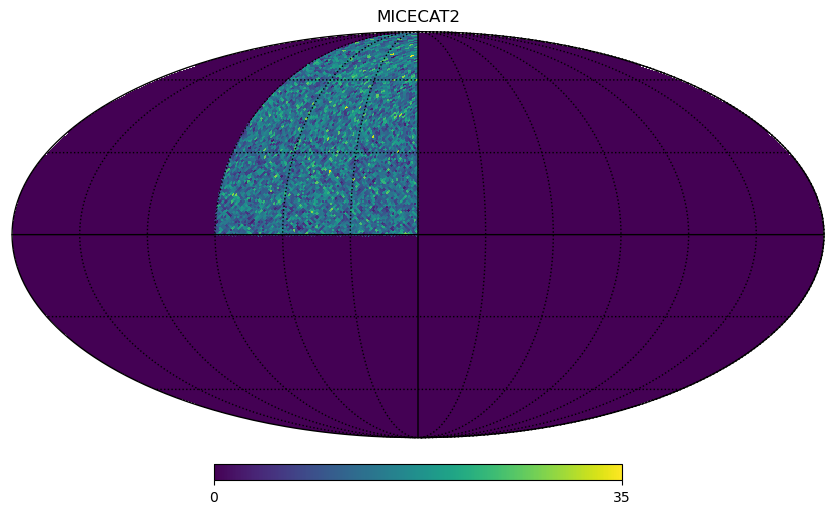

In [7]:
for i in range(num_bins):
    Healpix_map_i=Healpix_map(i, nside=64)
    visualize_healpix(Healpix_map_i)

## 2. Plotting the histogram

In [8]:
def plot_histogram_galaxies(bin_num, nside=64):
    for i in range(num_bins):
        Healpix_map_i = Healpix_map(i, nside=nside)
        plt.figure(figsize=(10, 6))
        mean_count = np.mean(Healpix_map_i[Healpix_map_i > 0])
        variance_count = np.var(Healpix_map_i[Healpix_map_i > 0])
        plt.axvline(mean_count+np.sqrt(variance_count), color='green', linestyle='dashed', linewidth=1.5, label=f'$\sigma$: {np.sqrt(variance_count):.2f}')
        plt.axvline(mean_count-np.sqrt(variance_count), color='green', linestyle='dashed', linewidth=1.5)
        plt.axvline(mean_count, color='red', linestyle='dashed', linewidth=1.5, label=f'$\mu$: {mean_count:.2f}')
        plt.legend()
        plt.hist(Healpix_map_i[Healpix_map_i > 0], bins=30, color='blue', alpha=0.7, edgecolor='black', linewidth=1.2)
        plt.xlabel('Counts per Healpix Pixel')
        plt.ylabel('Frequency')
        plt.title('Histogram of Counts per Healpix Pixel')
        plt.grid(True)
        plt.show()

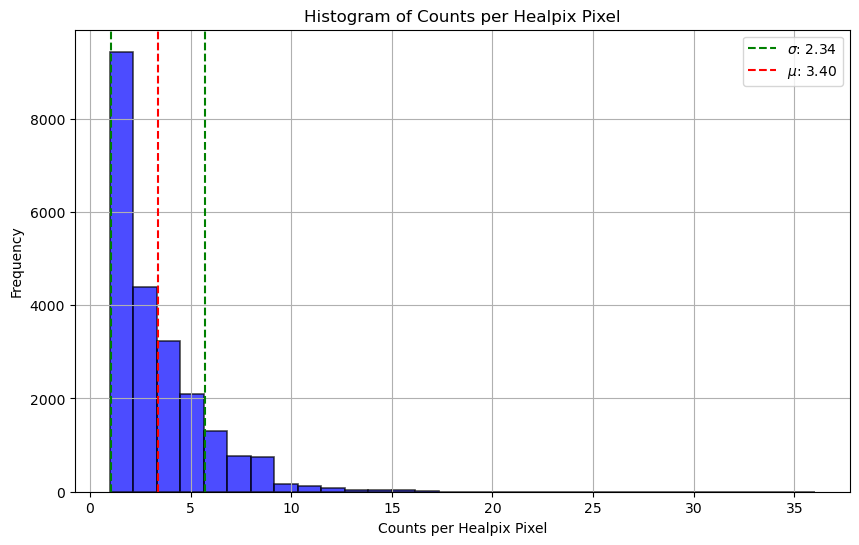

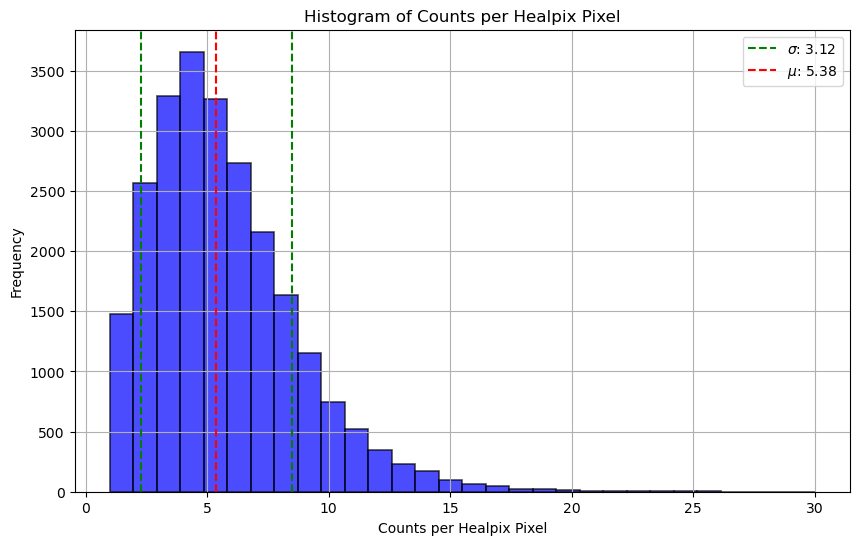

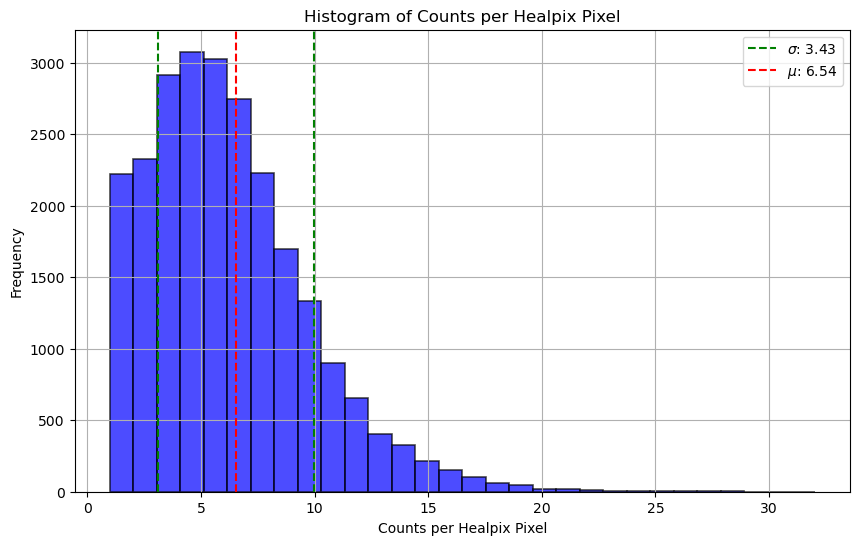

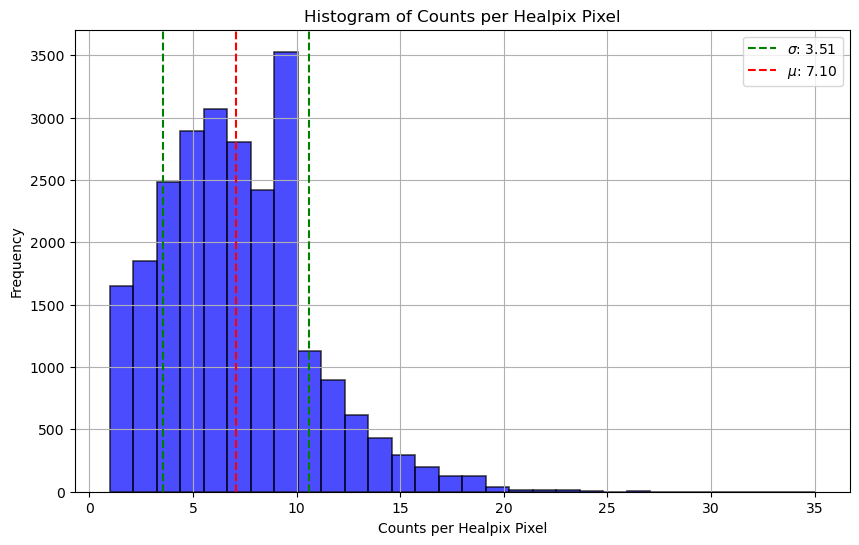

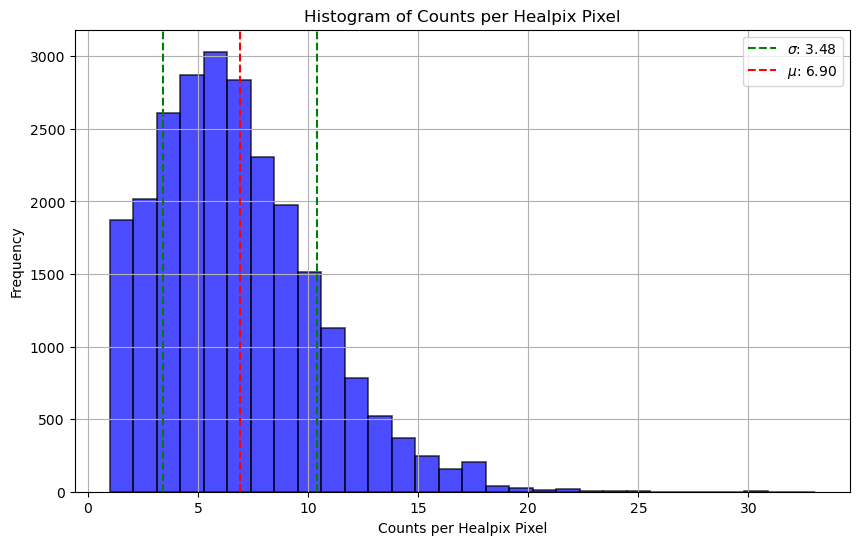

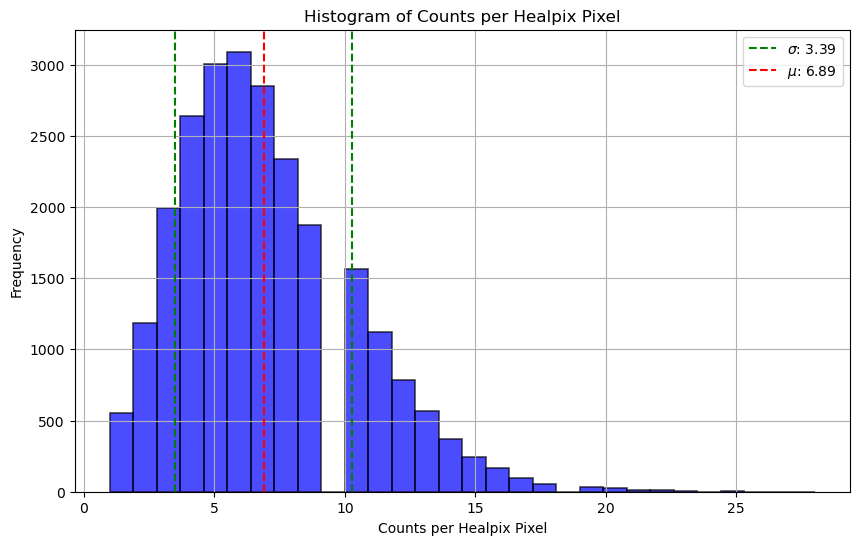

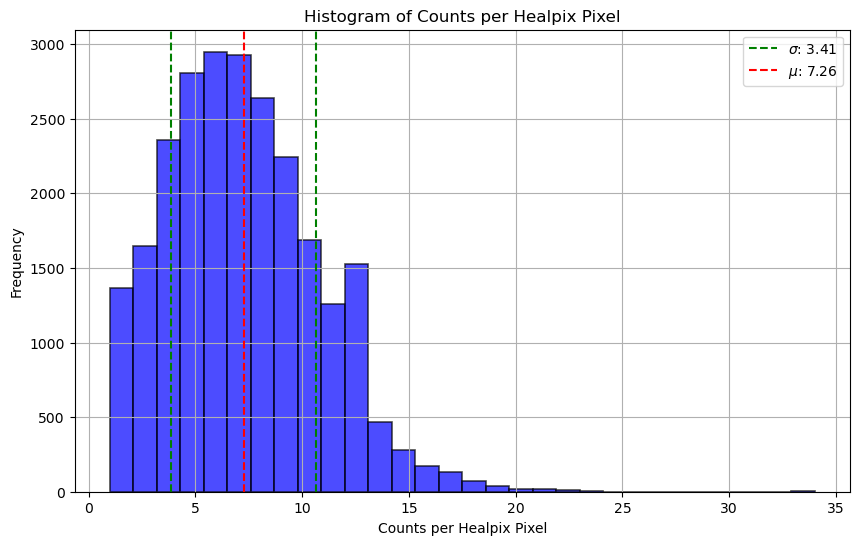

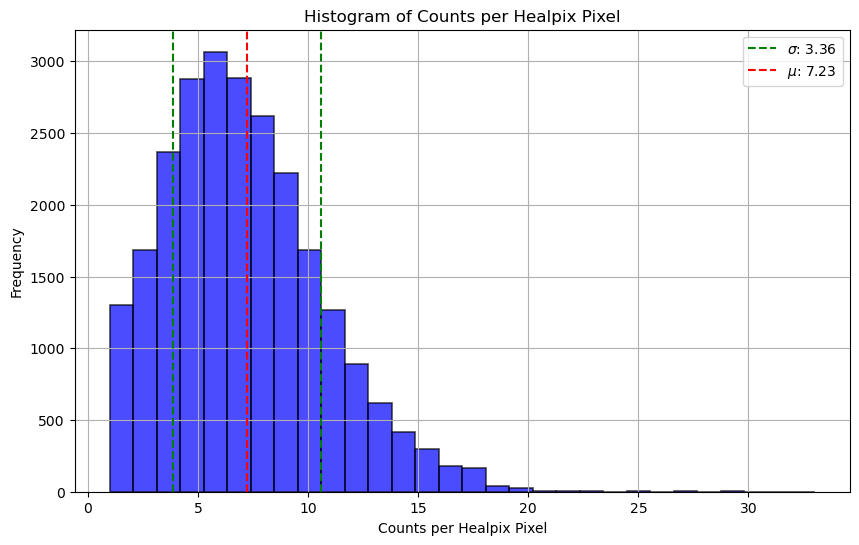

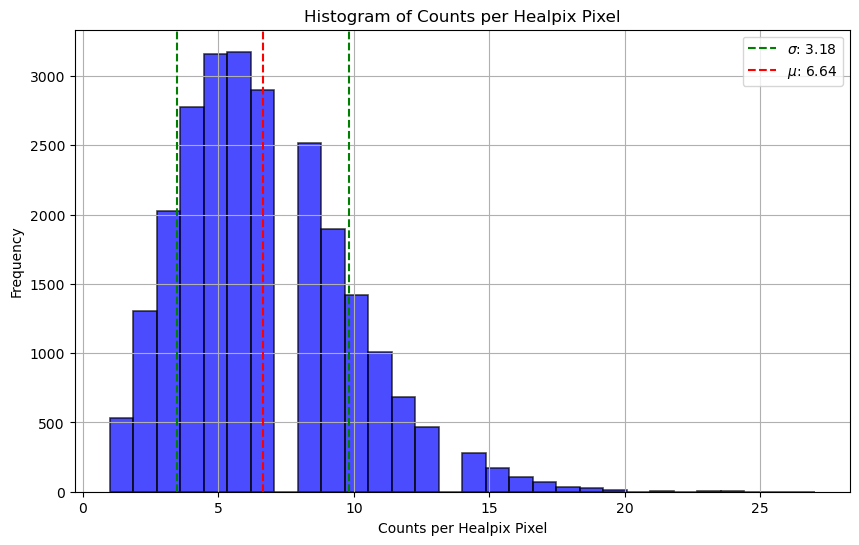

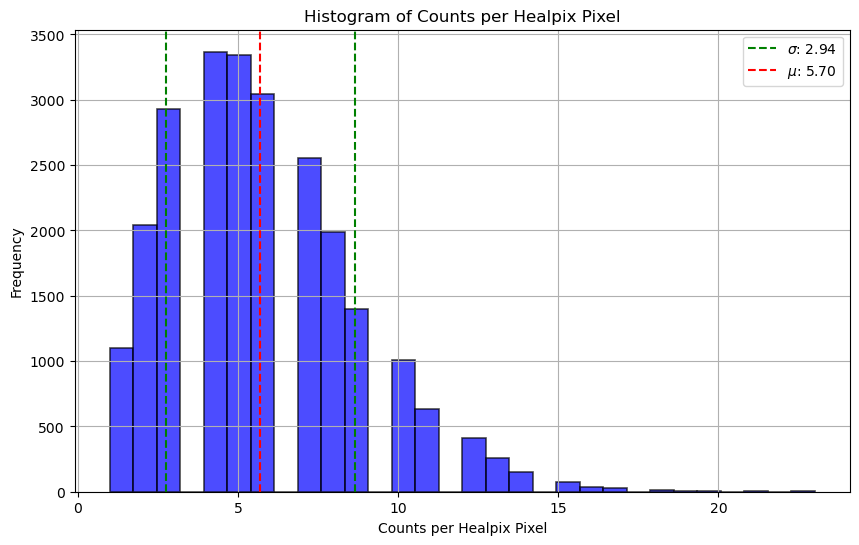

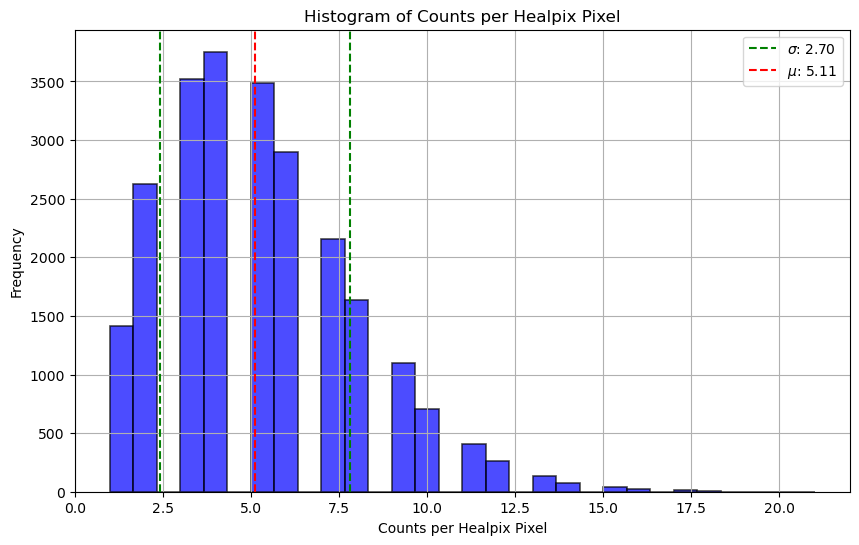

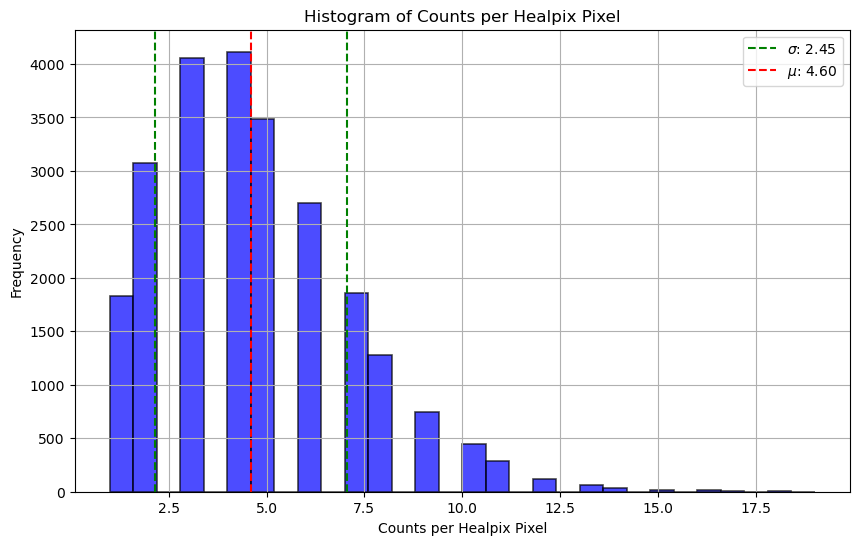

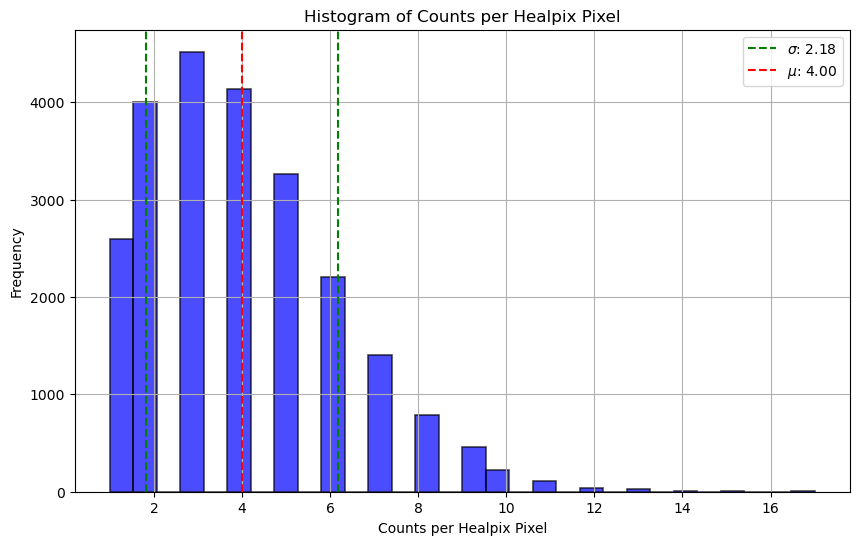

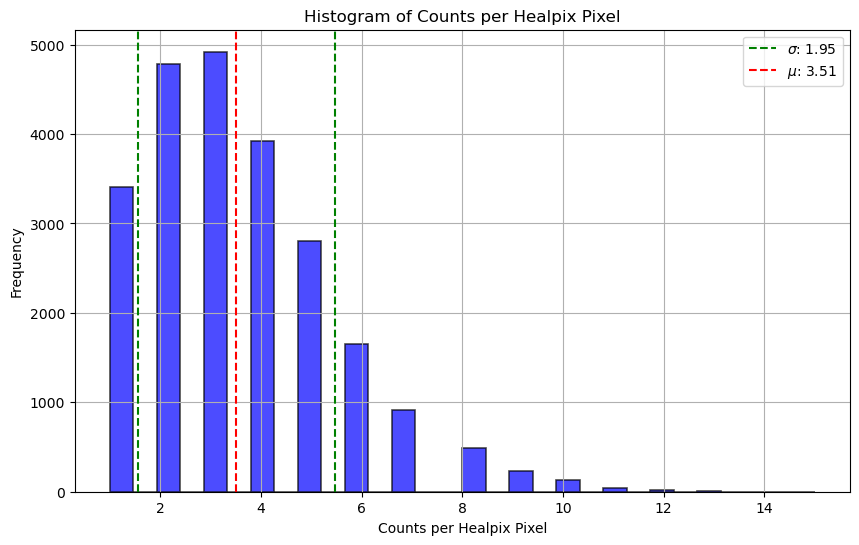

In [9]:
plot_histogram_galaxies(0, nside=128)

## 3. Plotting the mean number of galaxy counts against nside for given redshift bins.

In [10]:
def calculate_mean_variance(map_data):
    """
    Calculate the mean and variance of the given map data.
    
    Parameters:
    map_data (numpy.ndarray): The map data.
    nside (int): The nside parameter for HEALPix.
    
    Returns:
    tuple: mean and variance of the map data.
    """
    mean = np.mean(map_data[map_data > 0])
    #print(mean)
    variance = np.var(map_data[map_data > 0])
    return mean, variance

def visulaize_mean_variance(num_bins,nisdes):
    mean_values = []
    error_values = []
    
    for nside in nisdes:
        #print(f"Calculating for nside: {nside}")
        mean_bin = []
        error_bin = []
        for i in range(num_bins):
            #print(f"Calculating for bin: {i}")
            Healpix_map_i = Healpix_map(i, nside=nside)
            mean, variance = calculate_mean_variance(Healpix_map_i)
            mean_bin.append(mean)
            error_bin.append(np.sqrt(variance))
        mean_values.append(mean_bin)
        error_values.append(error_bin) 
    means = np.array(mean_values)
    errors = np.array(error_values)
    plt.figure(figsize=(10, 6))
    for bin_num in range(num_bins):
        plt.errorbar(nsides, means[:, bin_num], yerr=np.sqrt(errors[:, bin_num]), label=f'Bin {bin_num}', capsize=5)
    plt.xlabel('Nside')
    plt.ylabel('Mean Galaxy Count')
    plt.title('Mean Galaxy Count with Error Bars for Different Redshift Bins')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')
    plt.show()

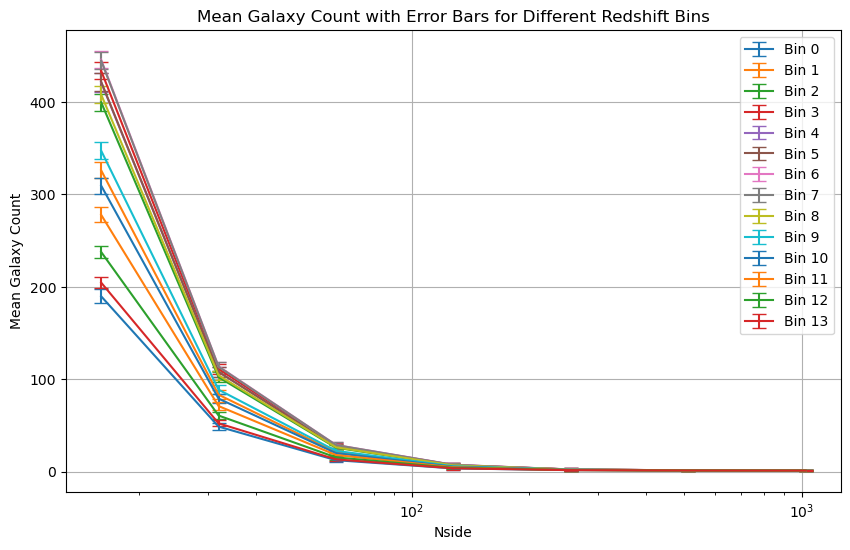

In [11]:
# Example usage
nsides = [16, 32, 64, 128, 256, 512, 1024]
visulaize_mean_variance(14,nsides)

Calculating for nside: 16
Calculating for bin: 0
Calculating for bin: 1
Calculating for bin: 2
Calculating for bin: 3
Calculating for bin: 4
Calculating for bin: 5
Calculating for bin: 6
Calculating for bin: 7
Calculating for bin: 8
Calculating for bin: 9
Calculating for bin: 10
Calculating for bin: 11
Calculating for bin: 12
Calculating for bin: 13
Calculating for nside: 32
Calculating for bin: 0
Calculating for bin: 1
Calculating for bin: 2
Calculating for bin: 3
Calculating for bin: 4
Calculating for bin: 5
Calculating for bin: 6
Calculating for bin: 7
Calculating for bin: 8
Calculating for bin: 9
Calculating for bin: 10
Calculating for bin: 11
Calculating for bin: 12
Calculating for bin: 13
Calculating for nside: 64
Calculating for bin: 0
Calculating for bin: 1
Calculating for bin: 2
Calculating for bin: 3
Calculating for bin: 4
Calculating for bin: 5
Calculating for bin: 6
Calculating for bin: 7
Calculating for bin: 8
Calculating for bin: 9
Calculating for bin: 10
Calculating for 

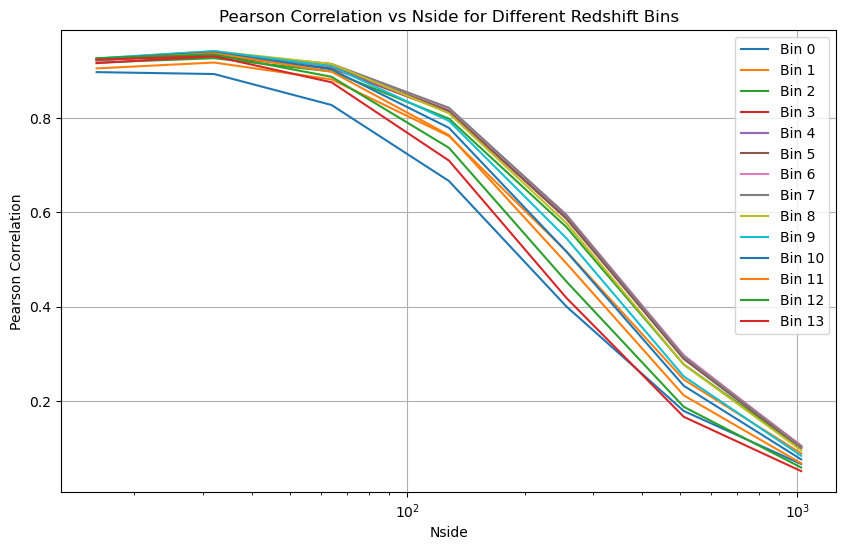

In [12]:
def get_pixel_neighbor_pairs(healpix_map, nside):
    """
    Generate pairs of pixel values and their neighboring pixel values.

    Parameters:
    healpix_map (numpy.ndarray): The HEALPix map data.
    nside (int): The nside parameter for HEALPix.

    Returns:
    numpy.ndarray: Array of pairs of pixel values and their neighboring pixel values.
    """
    npix = hp.nside2npix(nside)
    neighbors = hp.get_all_neighbours(nside, np.arange(npix))
    
    pairs = []
    for i in range(npix):
        pixel_value = healpix_map[i]
        neighbor_values = healpix_map[neighbors[:, i]]
        valid_neighbors = neighbor_values[neighbor_values >= 0]  # Filter out invalid neighbors
        
        for neighbor_value in valid_neighbors:
            pairs.append([pixel_value, neighbor_value])
    
    return np.array(pairs)

def calculate_pearson_correlation(pairs):
    """
    Calculate the Pearson correlation coefficient using pairs of pixel values.

    Parameters:
    pairs (numpy.ndarray): Array of pairs of pixel values and their neighboring pixel values.

    Returns:
    float: Pearson correlation coefficient.
    """
    if len(pairs) == 0:
        return np.nan
    
    pixel_values = pairs[:, 0]
    neighbor_values = pairs[:, 1]
    
    correlation = np.corrcoef(pixel_values, neighbor_values)[0, 1]
    return correlation

def visualize_pearson_correlation_vs_nside(correlations, nsides, num_bins):
    """
    Visualize the Pearson correlation coefficient against nside and compare the curve across multiple redshift bins.

    Parameters:
    correlations (numpy.ndarray): Array of Pearson correlation coefficients for different nsides and redshift bins.
    nsides (list): List of nside values.
    num_bins (int): Number of redshift bins.
    """
    plt.figure(figsize=(10, 6))
    for bin_num in range(num_bins):
        plt.plot(nsides, correlations[:, bin_num], label=f'Bin {bin_num}')
        
    plt.xlabel('Nside')
    plt.ylabel('Pearson Correlation')
    plt.title('Pearson Correlation vs Nside for Different Redshift Bins')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')
    plt.show()

# Example usage
correlations = []
for nside in nsides:
    print(f"Calculating for nside: {nside}")
    correlation_bin = []
    for bin_num in range(num_bins):
        print(f"Calculating for bin: {bin_num}")
        Healpix_map_i = Healpix_map(bin_num, nside=nside)
        pairs = get_pixel_neighbor_pairs(Healpix_map_i, nside)
        correlation = calculate_pearson_correlation(pairs)
        correlation_bin.append(correlation)
    correlations.append(correlation_bin)

correlations = np.array(correlations)
visualize_pearson_correlation_vs_nside(correlations, nsides, num_bins)

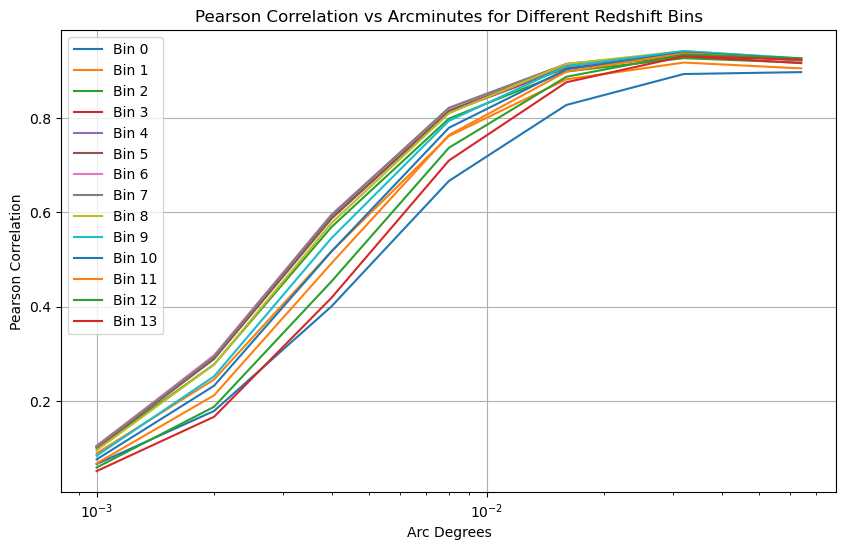

In [15]:
arcmins = [hp.nside2resol(nside) for nside in nsides]

plt.figure(figsize=(10, 6))
for bin_num in range(num_bins):
    plt.plot(arcmins, correlations[:, bin_num], label=f'Bin {bin_num}')
    
plt.xlabel('Arc Degrees')
plt.ylabel('Pearson Correlation')
plt.title('Pearson Correlation vs Arcminutes for Different Redshift Bins')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.show()